# Text Detection Network

The goal of this notebook is to build, train, and evaluate a **fully-convolutional network** for **text detection**. The input of the network is a color image containing text while the output is a set of **bounding boxes** indicating the **location** of text inside the input image.

![text_detection](./imgs/detection.png)

The training and evaluation of the network is done using a **synthetic text dataset** containing random words over diverse and challenging backgrounds. 

**Requirements:**
This notebook requires the following libraries:
+ Numpy
+ Tensorflow
+ Matplotlib
+ PIL

**Michael Villamizar** <br>
michael.villamizar@idiap.ch <br>
http://www.michael-villamizar.com <br>
Idiap Research Institute <br>
Switzerland - 2019 <br>


In [1]:
# Libraries.
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Additional libraries.
import evaluation as eval  # Code for text detection evaluation.

### Synthetic Text Dataset (STD)

The synthetic text dataset has color images of **112x112** pixels with **random words** over diverse backgrounds. **Single** words appear at different locations, fonts, sizes, and colors in order to increase the difficulty of the problem. Some example images are shown below:

![dataset examples](./imgs/examples.png)

Each image has associated an **annotation mask** -ground truth- indicating the location of the word using a bounding box. For the current dataset, the annotation mask is a **feature grid** of 14x14 cells and **5 features** depth. Each cell has size of 8x8 pixels. The first feature corresponds to the **confidence** that indicates the presence of text in any cell. For example, if the center of the word falls inside *cell_i*, the confidence *c_i* is set to 1. Otherwise, *c_i* is 0. The rest features correspond to the **coordinates** of the bounding box (x, y, width, height) relative to the center of the cell.
This is illustrated in the following figure. 

![dataset_annotation](./imgs/dataset_annotation.png)

TSD comprises three different sets: **training**, **validation** and **test** sets. The former is used to compute the network whereas the validation set is used to tune the network parameters. The test set is used for evaluation **only**.

In [2]:
# Dataset path.
dat_path = './data/dataset.p'

# Load the Synthetic Text Dataset (TSD).
def load_dataset(path):

    # Load pickle dataset file.
    dataset = pickle.load(open(path,'rb'))

    # Print dataset information.
    info = dataset['info']
    print('Synthetic text dataset:')
    print('+ Num. train images: {0}'.format(info['num_train_images']))
    print('+ Num. validation images: {0}'.format(info['num_valid_images']))
    print('+ Num. test images: {0}'.format(info['num_test_images']))
    print('+ Input size: {0}'.format(info['image_size']))  # Image size -pixels-.
    print('+ Output size: {0}'.format(info['grid_size']))  # Feature grid size -cells-.
    print('+ Cell size: {0}'.format(info['cell_size']))  # Grid cell size -pixels-.

    return dataset

# Load synthetic text dataset.
dataset = load_dataset(dat_path)

# Dataset values.
input_size = dataset['info']['image_size']
output_size = dataset['info']['grid_size']
cell_size = dataset['info']['cell_size']

Synthetic text dataset:
+ Num. train images: 4000
+ Num. validation images: 500
+ Num. test images: 500
+ Input size: (112, 112)
+ Output size: (14, 14)
+ Cell size: (8, 8)


### Examples

Some example images used for training are shown below.
Each image contains random background and artificial text.

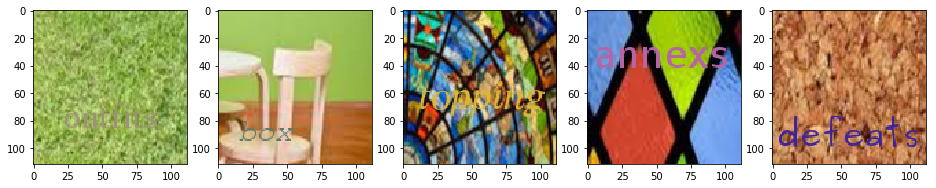

In [3]:
# Show example images chosen at random.
def show_examples(images, num_examples):
    
    # Number of images.
    num_imgs = np.shape(images)[0]
    
    # Figure.
    fig = plt.figure(figsize=(16, 10))
    for i in range(num_examples):
        # Random image index.
        index = np.random.randint(0, num_imgs)
        # Show current example image.
        ax = fig.add_subplot(1, num_examples, i+1)
        ax.imshow(np.uint8(images[index, :, :, :]))
    plt.show()

# Show example images.
show_examples(dataset['train_images'], num_examples=5)

### Normalize Images

All images are normalized to have pixel values in the range [-0.5, 0.5]. The images are initially unsigned integers between 0 and 255.

In [5]:
# Normalize images.
def normalize_images(images):
    return images.astype(np.float32) / 255.0 - 0.5
  
# Normalize training, validation and test images.
train_images = normalize_images(dataset['train_images'])
valid_images = normalize_images(dataset['valid_images'])
test_images = normalize_images(dataset['test_images'])

### Data Class
This class contains and manages images and annotation masks. The 
class also provides mini-batches of images and annotation masks.

In [6]:
# Data Class
class Data():
    def __init__(self, images, masks, shuffle=True):

        # Parameters.
        self.index = 0  # Iteration index.
        self.images = images  # Images.
        self.masks = masks  # Annotation masks.
        self.shuffle = shuffle  # Suffle batches.
          
        # Check the number of images and annotation masks.
        assert np.shape(images)[0] == np.shape(masks)[0]
        
        # Number of images.
        self.num_images = np.shape(self.images)[0]
        
        # Image list.
        self.list = np.arange(self.num_images)
        
        # Suffle image indexes.
        if self.shuffle:
            np.random.shuffle(self.list)
    
    # Next batch.
    def next_batch(self, batch_size):
        
        # Reset iteration index.
        if self.index+batch_size > self.num_images:
            self.index = 0
        
        # Image indexes.
        indxs = self.list[self.index:self.index+batch_size]
    
        # Update iteration index.
        self.index += batch_size
        
        # Batch.
        y_batch = self.masks[indxs, :, :, :]
        x_batch = self.images[indxs, :, :, :]
        
        return x_batch, y_batch
        
# Compute training, validation and test data.   
train_data = Data(train_images, dataset['train_labels'], shuffle=True)
valid_data = Data(valid_images, dataset['valid_labels'], shuffle=True)
test_data = Data(test_images, dataset['test_labels'], shuffle=False)

# Delete variables.
#del dataset, train_images, valid_images, test_images

### Network Computation

The following scheme shows the **default** network used for text detection. This network is a **fully** convolutional network including 4 **convolutional** layers and 3 **max-pooling** layers. The last layer is a **linear** layer to return the confidence and the coordinates of the bounding box. All convolutional filters have a size of 3x3.

![network](./imgs/network.png)

***Note:*** The number of max-pooling layers must be 3 in order to get the feature grid size (14x14 cells).


### Network Class

The text detection network class is defined below with all functions to train and evaluate the network on the synthetic text dataset.

In [7]:
# Text detection network class.
class Text_Detection_Network():      
    
    # Initialize.
    def __init__(self, network_arq, batch_size, input_size, output_size, gpu=True):
            
        # Parameters.
        self.input_depth = 3  # Number of image channels [RGB image].
        self.output_depth = 5  # Number of feature output channels [confidence + box coord.]
        self.batch_size = batch_size  # Batch size.
        self.input_size = input_size  # Input image size -pixels-.
        self.output_size = output_size  # Feature grid size -cells-.
        self.network_arq = network_arq  # Network architecture.
        self.num_layers = len(network_arq)  # Number of layers.
        
        # Tensorflow graph.
        graph = tf.Graph()
        with graph.as_default():
        
            # Define placeholders: x-image, y-annotation mask, t-training flag.
            self.x, self.y, self.t = self.placeholders()
        
            # Initialize network variables: weights and bias.
            self.weights, self.biases = self.initialize_variables()
        
            # Network.
            self.pred = self.network()
        
            # Define loss.
            self.loss = self.compute_loss()
        
            # Optimizer.
            self.optimizer = self.compute_optimizer() 
        
        # gpu configuration.
        if gpu:
            config = self.gpu_configuration()

        # Launch the session
        self.sess = tf.InteractiveSession(config=config, graph=graph)
        self.sess.run(tf.global_variables_initializer())
        
    # Placeholders
    def placeholders(self):
        ''' This function defines the placeholders for network computation. '''

        # Placeholder for images -batch of images-.
        x = tf.placeholder(tf.float32, [self.batch_size, self.input_size[0], \
                                        self.input_size[1], self.input_depth], \
                                        name='x_img')
        # Placeholder for annotation masks -batch of masks-.
        y = tf.placeholder(tf.float32, [self.batch_size, self.output_size[0], \
                                        self.output_size[1], self.output_depth], \
                                        name='y_mask')
        # Placeholder for batch normalization. This indicates if the network is 
        # during training phase.
        t = tf.placeholder(tf.bool, [], name='train_phase')

        return x, y, t
        
    # Weights.
    def compute_weights(self, size_in, size_out, filter_width, filter_height, name='w'):
        ''' This function computes and initializes weights for a convolutional filter.'''
        return tf.Variable(tf.truncated_normal([filter_height, filter_width, \
                                                size_in, size_out], stddev=0.1), name=name)
    # Biases.
    def compute_biases(self, size_out, name='b'):
        ''' This function computes and initializes biases. '''
        return tf.Variable(tf.constant(0.0, shape=[size_out]), name=name)
    
    # Initialize variables.    
    def initialize_variables(self):    
        '''This function initializes the network variables: weights and biases for 
        all layers.'''
      
        # Check that the networks has more than 2 layers.
        assert self.num_layers > 2
    
        # Newtork weights and biases.
        biases = {}
        weights = {}
        
        # Input feature depth.
        prev_depth = self.input_depth # RGB image.
        
        # Layers.
        for i in range(self.num_layers):
           
            # Current layer.
            layer = 'layer_{0}'.format(i)
            
            # Filter size and number of feature channels -maps-.
            fsize = self.network_arq[layer]['filter_size']
            depth = self.network_arq[layer]['layer_depth']
    
            # Check that last layer has the right layer depth (depth = 5).
            if i == self.num_layers - 1:
                assert depth == self.output_depth
     
            # Variables: weights and biases.
            biases[layer] = self.compute_biases(depth, 'b{0}'.format(i))
            weights[layer] = self.compute_weights(prev_depth, depth, fsize[0], \
                                                  fsize[1], 'w{0}'.format(i))
            # Update previous depth.
            prev_depth = depth
           
        return weights, biases
    
    # Convolutional layer + batch normalization.
    def conv_bn_layer(self, input, weights, bias, name='conv_bn'):
        ''' This function computes a convolutional layer with batch normalization 
        and ReLU activation function.'''

        with tf.name_scope(name):
            # Convolution.
            c = tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='SAME')
            d = tf.nn.bias_add(c, bias) ## Add bias.
            # Batch normalization.
            bn = tf.contrib.layers.batch_norm(d, is_training=self.t, center=True, \
                                              scale=True, updates_collections=None, \
                                              decay=0.9, scope=name)
            # Activation function.
            a = tf.nn.relu(bn)  # ReLU.
        
        return a
        
    # Linear layer.
    def conv_lin_layer(self, input, weights, bias, name='conv_lin'):
        ''' This function computes a convolutional layer with linear output. '''
        
        with tf.name_scope(name):
            # Convolution.
            c = tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='SAME')
            a = tf.nn.bias_add(c, bias) ## Add bias.
         
        return a

    # Max pooling layer.
    def max_pool(self, input, name='pool'):
        ''' This function computes a max-pooling layer (2x2). '''

        with tf.name_scope(name):
            # Operation: max pooling.
            p = tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], \
                               padding='SAME')
        return p

    # Network.
    def network(self):
        ''' This function defines the deep network for text detection. It is a 
        fully-convolutional network cosisting of several convolutional layers followed 
        by a ReLU activation function. The last layer is a linear convolutional layer.
        The network has three max-pooling operations to get the size of output feature 
        grid. '''
        
        # Network input -color image-.
        x = self.x
        
        # Scope.
        with tf.name_scope('network'):
         
            # Layers.
            for i in range(self.num_layers):
                
                # Current layer.
                l = 'layer_{0}'.format(i)  # Layer name.
                n = 'c{0}'.format(i)  # Operation name
             
                # Convolutional layers. The last layer has linear output.
                if i < self.num_layers - 1:
                    # Convolutional layer + batch normalization + ReLU.    
                    x = self.conv_bn_layer(x, self.weights[l], self.biases[l], n)
                else:
                    # Convolutional linear layer.    
                    x = self.conv_lin_layer(x, self.weights[l], self.biases[l], n)
                
                # Max- pooling.
                if i < 3:
                    x = self.max_pool(x, 'p{0}'.format(n))
        return x
    
    # Compute loss.
    def compute_loss(self):
        ''' This function computes the loss using weighted mean-squared-error. '''

        with tf.name_scope('loss'):
            
            # Loss weights computation.
            k1 = 10  # Weight for detection confidences.
            k2 = 5  # Weight for box coordinates estimation.
            # Annotation mask slice.
            ys = tf.slice(self.y, [0, 0, 0, 0], [self.batch_size, self.output_size[0], \
                                                 self.output_size[1], 1], 'y_slice')
            weights = tf.concat([(k1-1)*ys+1, k2*ys, k2*ys, k2*ys, k2*ys], 3)
            
            # Weigthed mean-squared error between the network prediction and 
            # annotation mask.
            loss = tf.reduce_mean(tf.multiply(tf.squared_difference(self.pred, \
                                                                    self.y), weights))
        return loss
    
    # Optimizer.
    def compute_optimizer(self):
        ''' This function computes the optimizer (Adam optimizer)... '''

        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer().minimize(self.loss)

        return optimizer
            
    # GPU configuration.
    def gpu_configuration(self):
        ''' This function sets up the GPU configuration. '''

        # Config for gpu memory.
        config = tf.ConfigProto()
        config.log_device_placement = False
        config.gpu_options.allow_growth = True
        config.gpu_options.allocator_type = "BFC"

        return config

    # Run partial fit.
    def run_partial_fit(self, x_batch, y_batch, train):
        ''' This function fits the network with the input mini-batch.'''
        
        # Partial fit -run optimizer-.
        self.sess.run([self.optimizer], \
                      feed_dict={self.x: x_batch, self.y: y_batch, self.t:train})
    
    # Run network.
    def run_network(self, x_batch, y_batch, train):
        ''' This function runs the network on the input mini-batch. '''
    
        # Run network.
        pred, loss = self.sess.run([self.pred, self.loss], \
                                   feed_dict={self.x: x_batch, self.y: y_batch, \
                                              self.t:train})
        return pred, loss
    
    # Train network.
    def train_network(self, num_train_steps):
        ''' This function trains the network using the synthetic text dataset. '''

        # Message.
        print('Training:')
        print('  [Step] [train|validation loss] [train|validation f-score]')

        # Train and validation losses and accuracies.
        vec_train_loss = []
        vec_valid_loss = []
        vec_train_accu = []
        vec_valid_accu = []
        
        # Training iterations.
        for s in range(num_train_steps):
        
            # Mini-batch [training data].
            x_batch, y_batch = train_data.next_batch(self.batch_size)
            
            # Run optimizer.
            self.run_partial_fit(x_batch, y_batch, True)

            # Compute network performance.
            if (s+1) % 100 == 0:
                
                # Prediction and loss for training mini-batch.
                train_pred, train_loss = self.run_network(x_batch, y_batch, False)
                
                # Text detection rates for training mini-batch.
                train_rates = eval.fun_text_detection_accuracy(train_pred, y_batch, \
                                                               cell_size)
                # Mini-batch [validation data].
                x_batch, y_batch = valid_data.next_batch(self.batch_size)
                
                # Prediction and loss for validation mini-batch.
                valid_pred, valid_loss = self.run_network(x_batch, y_batch, False)
                
                # Text detection rates for validation mini-batch.
                valid_rates = eval.fun_text_detection_accuracy(valid_pred, y_batch, \
                                                               cell_size)
                # Message.
                print('  [Step: {0}/{1}] '.format(s+1, num_train_steps) + \
                      '[Loss: {0:.3f}|{1:.03f}] '.format(train_loss, valid_loss) +
                      '[F-score: {0:.3f}|{1:.3f}] '.format(train_rates[5], \
                                                            valid_rates[5]))
                
                # Save train and validation losses and accuracies.
                vec_train_loss.append(train_loss)
                vec_valid_loss.append(valid_loss)
                vec_train_accu.append(train_rates[5])
                vec_valid_accu.append(valid_rates[5])
        
        # Plot training and validation loss.    
        fig = plt.figure(figsize=(16, 6))
        x = range(0, num_train_steps, 100)
        plt.plot(x, vec_train_loss, 'r-', linewidth=6, label='Train')
        plt.plot(x, vec_valid_loss, 'b-', linewidth=6, label='Validation')
        plt.legend(fontsize=22)
        plt.ylabel('Loss', fontsize=18), plt.xlabel('Steps', fontsize=18)
        plt.grid(), plt.show()

        # Plot training and validation f-score.
        fig = plt.figure(figsize=(16,6))
        plt.plot(x, vec_train_accu, 'r-', linewidth=6, label='Train')
        plt.plot(x, vec_valid_accu, 'b-', linewidth=6, label='Validation')
        plt.legend(fontsize=22)
        plt.ylabel('F-score', fontsize=18), plt.xlabel('Steps', fontsize=18)
        plt.grid(), plt.show()
        
    # Evaluate network.
    def evaluate(self):
        ''' This function evaluates the network on the test set of the synthetic 
        text dataset. '''
      
        # Check that all test images are evaluated.
        assert test_data.num_images % self.batch_size == 0
        
        # Reset test data index.
        test_data.index = 0
        
        # Test steps.
        for s in range(test_data.num_images/self.batch_size):
        
            # Mini-batch [test data].
            x_batch, y_batch = test_data.next_batch(self.batch_size)
            
            # Prediction and test loss
            test_pred, test_loss = self.run_network(x_batch, y_batch, False)

            # Store all predictions.
            if s==0: all_pred = test_pred
            if s>0: all_pred = np.vstack((all_pred, test_pred))

        # Text detection rates for test data -all images-.
        rates = eval.fun_text_detection_accuracy(all_pred, test_data.masks, cell_size)
        
        return rates

### Initialize Network
The network is initialized with the given batch size and network architecture.

In [15]:
# Parameters.
batch_size = 5

# Network architecture.
# Note: The use of rectangular filters (eg. 7x3) improves text detection scores.
net_arq = {'layer_0':{'layer_depth':32, 'filter_size':(3, 3)},\
           'layer_1':{'layer_depth':32, 'filter_size':(3, 3)},\
           'layer_2':{'layer_depth':64, 'filter_size':(3, 3)},\
           'layer_3':{'layer_depth':128, 'filter_size':(3, 3)},\
           'layer_4':{'layer_depth':64, 'filter_size':(3, 3)},\
           'layer_5':{'layer_depth':5, 'filter_size':(3, 3)},\
          }

# Network.
textnet = Text_Detection_Network(net_arq, batch_size, input_size, output_size)

### Train Network
The network is trained with the training and validation data.

Training:
  [Step] [train|validation loss] [train|validation f-score]
  [Step: 100/2000] [Loss: 0.032|0.012] [F-score: 0.750|0.750] 
  [Step: 200/2000] [Loss: 0.020|0.018] [F-score: 0.571|0.667] 
  [Step: 300/2000] [Loss: 0.017|0.008] [F-score: 0.545|0.889] 
  [Step: 400/2000] [Loss: 0.008|0.024] [F-score: 0.750|0.800] 
  [Step: 500/2000] [Loss: 0.013|0.011] [F-score: 0.889|0.667] 
  [Step: 600/2000] [Loss: 0.019|0.011] [F-score: 0.600|0.667] 
  [Step: 700/2000] [Loss: 0.010|0.011] [F-score: 0.667|1.000] 
  [Step: 800/2000] [Loss: 0.009|0.008] [F-score: 1.000|0.889] 
  [Step: 900/2000] [Loss: 0.026|0.016] [F-score: 0.889|0.889] 
  [Step: 1000/2000] [Loss: 0.019|0.007] [F-score: 0.571|0.889] 
  [Step: 1100/2000] [Loss: 0.015|0.011] [F-score: 0.364|1.000] 
  [Step: 1200/2000] [Loss: 0.007|0.017] [F-score: 0.889|0.889] 
  [Step: 1300/2000] [Loss: 0.012|0.012] [F-score: 1.000|0.889] 
  [Step: 1400/2000] [Loss: 0.017|0.007] [F-score: 0.600|0.889] 
  [Step: 1500/2000] [Loss: 0.011|0.007] [F-

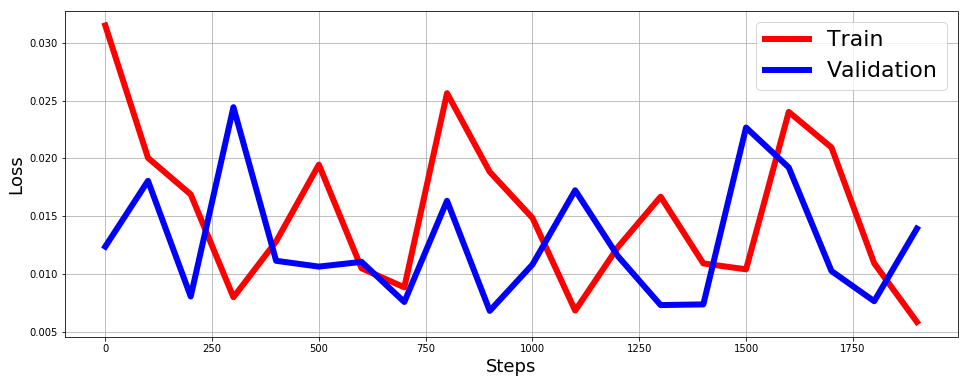

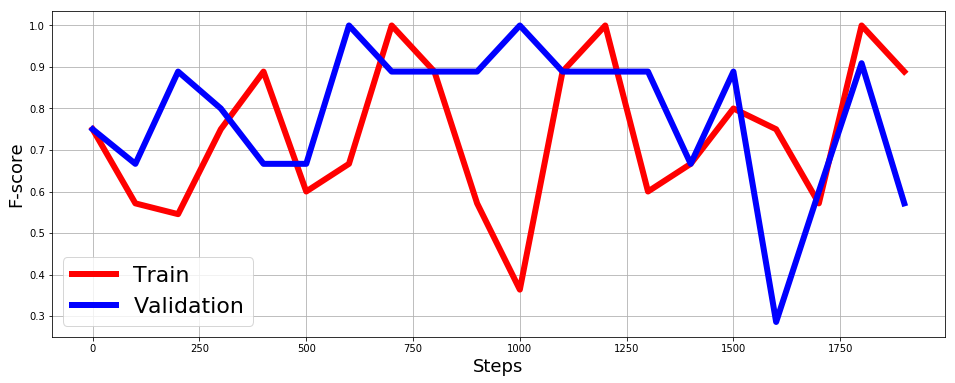

In [43]:
# Train Network.
num_train_steps = 2000
rates = textnet.train_network(num_train_steps)

### Text Detection Evaluation
The network is evaluated on the test set of the synthetic text dataset.

In [44]:
# Evaluate the network.
rates = textnet.evaluate()

# Messages.
print('Text detection rates:')
print('+ Recall: {0:.3f}'.format(rates[3]))
print('+ Precision: {0:.3f}'.format(rates[4]))
print('+ F-score: {0:.3f}'.format(rates[5]))
print('+ True positives: {0:.0f}'.format(rates[0]))
print('+ False positives: {0:.0f}'.format(rates[1]))
print('+ False negatives: {0:.0f}'.format(rates[2]))


Text detection rates:
+ Recall: 0.662
+ Precision: 0.917
+ F-score: 0.769
+ True positives: 331
+ False positives: 30
+ False negatives: 169


### Text Detection Results
Next, the output of the network is shown for text detection.

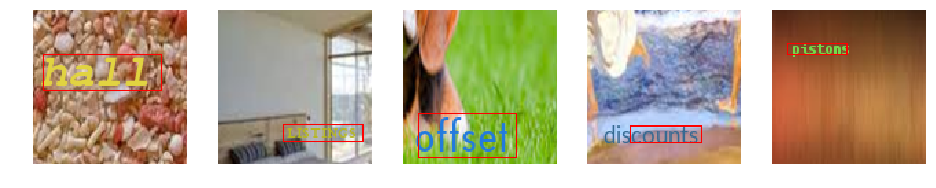

In [102]:
# Get test mini-batch.
x_batch, y_batch = test_data.next_batch(batch_size)

# Run the network on the mini-batch
test_pred, _ = textnet.run_network(x_batch, y_batch, False)

# Network output: It shows the text detections in the last test mini-batch.
imgs = 255*(x_batch + 0.5)  # Scale between 0 and 255.
imgs = eval.fun_draw_text_boxes(imgs, test_pred, cell_size)

# Figure.
fig = plt.figure(figsize=(16,10))
for i in range(batch_size):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(np.uint8(imgs[i,:,:,:]))
    ax.axis('off')
plt.show()